## Note: This notebook will run about 2 hrs and 37 mins on my computer (Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz; RAM: 32.0 GB).

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import pyodbc
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import imblearn
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,SVMSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from helper_function import bayes_tuning,grid_tuning,plot_models_comp,plot_cv_vs_test

In [116]:
print('python version:'+sys.version)
print('packages:\n'+'\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
print('pyodbc=='+pyodbc.version)

python version:3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
packages:
numpy==1.20.2
pandas==1.0.5
seaborn==0.11.0
xgboost==1.4.2
pip==21.2.4
skopt==0.9.dev0
sklearn==0.24.2
imblearn==0.7.0
pyodbc==4.0.0-unsupported


In [30]:
#ingore all warnings to show nicely
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)
#to show more rows and columns in pandas Dataframe
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

# Loading data files

## We use quality of care data from 2013-2015, due to the data acquisition of this database has two-year's delay, the data of hospital compare 2017 is actually 2015's, and so on. Our datasets' names are based on the hospital compare data aquisition year.

In [100]:
#loading closed hospital information
dataset_close_status=pd.read_csv('data\hospital_closure\hospital_closure.csv')

#loading Hospital Compare AHRQ data connect from MS Access files(.mdb)  
MDB_2017='data\hospital_compare\hc_apr2017\Hospital.mdb'
MDB_2016 = 'data\hospital_compare\hc_may2016\Hospital.mdb'
MDB_2015='data\hospital_compare\Copy of HospitalMay2015.mdb'
MDB_2014='data\hospital_compare\HC_May2014.mdb'
DRV = '{Microsoft Access Driver (*.mdb, *.accdb)}'
PWD = 'pw'
con_2017 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2017,PWD))
con_2016 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2016,PWD))
con_2015 = pyodbc.connect('DRIVER={};DBQ={};PWD={}'.format(DRV,MDB_2015,PWD))
cur_2017 = con_2017.cursor()
cur_2016 = con_2016.cursor()
cur_2015 = con_2015.cursor()

#SQL query to access data
table_name = 'HQI_HOSP_ReadmDeath'
table_name2='HQI_HOSP_ReadmCompDeath'
table_name3='HQI_HOSP_Comp'
query = "SELECT * FROM {}".format(table_name)
query2="SELECT * FROM {}".format(table_name2)
query3="SELECT * FROM {}".format(table_name3)
rows_2017=cur_2017.execute(query).fetchall()
rows_2017_c=cur_2017.execute(query3).fetchall()
rows_2016=cur_2016.execute(query).fetchall()
rows_2016_c=cur_2016.execute(query3).fetchall()
rows_2015=cur_2015.execute(query2).fetchall()

#generate pandas Dataframe using the scores of each variable
arr_2017=np.array(rows_2017)
dataset_2017=pd.DataFrame(arr_2017[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2017_c=np.array(rows_2017_c)
dataset_2017_c=pd.DataFrame(arr_2017_c[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2016=np.array(rows_2016)
dataset_2016=pd.DataFrame(arr_2016[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2016_c=np.array(rows_2016_c)
dataset_2016_c=pd.DataFrame(arr_2016_c[:,[0,3,6]],columns=['id','score_name','Score'])
arr_2015=np.array(rows_2015)
dataset_2015=pd.DataFrame(arr_2015[:,[0,3,6]],columns=['id','score_name','Score'])


# Data Preprocessing

## Match the data from different years

In [101]:
#drop abnormal Hospitals with 'F' in the provider ID
dataset_2015=dataset_2015[dataset_2015['id'].map(lambda x: x.find('F')==-1)]
dataset_2015.drop(dataset_2015[dataset_2015.id=='670092'].index,inplace=True)
dataset_2016=dataset_2016[dataset_2016['id'].map(lambda x: x.find('F')==-1)]
dataset_2016_c=dataset_2016_c[dataset_2016_c['id'].map(lambda x: x.find('F')==-1)]

#combine the data of different variables in the same year
dataset_2016=pd.concat([dataset_2016,dataset_2016_c],axis=0)
dataset_2017=pd.concat([dataset_2017,dataset_2017_c],axis=0)

#re-sort the datasets
dataset_2015.sort_values(by=['id','score_name'],inplace=True)
dataset_2016.sort_values(by=['id','score_name'],inplace=True)
dataset_2017.sort_values(by=['id','score_name'],inplace=True)

In [102]:
#manually flatten the variables
dataset_2015_num=dataset_2015[['id','Score']].to_numpy().reshape(int(dataset_2015.id.value_counts().ne(1).sum()),int(dataset_2015.score_name.value_counts().ne(0).sum()*2))
dataset_2016_num=dataset_2016[['id','Score']].to_numpy().reshape(int(dataset_2016.id.value_counts().ne(1).sum()),int(dataset_2016.score_name.value_counts().ne(0).sum()*2))
dataset_2017_num=dataset_2017[['id','Score']].to_numpy().reshape(int(dataset_2017.id.value_counts().ne(1).sum()),int(dataset_2017.score_name.value_counts().ne(0).sum()*2))
arr_2015=[i*2 for i in range(dataset_2015.score_name.value_counts().ne(0).sum())]
arr_2016=[i*2 for i in range(dataset_2016.score_name.value_counts().ne(0).sum())]
arr_2017=[i*2 for i in range(dataset_2017.score_name.value_counts().ne(0).sum())]
dataset_2015=np.delete(dataset_2015_num,arr_2015[1:],axis=1)
dataset_2016=np.delete(dataset_2016_num,arr_2016[1:],axis=1)
dataset_2017=np.delete(dataset_2017_num,arr_2017[1:],axis=1)
dataset_2015=pd.DataFrame(dataset_2015,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])
dataset_2016=pd.DataFrame(dataset_2016,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_CABG','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_CABG','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])
dataset_2017=pd.DataFrame(dataset_2017,columns=['id','COMP_HIP_KNEE','MORT_30_AMI','MORT_30_CABG','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_13_POST_SEPSIS','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_3_ULCER','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_7_CVCBI','PSI_8_POST_HIP','PSI_90_SAFETY','READM_30_AMI','READM_30_CABG','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'])

In [103]:
#drop the non-common variables in different years
dataset_2016.drop(columns=['MORT_30_CABG','READM_30_CABG'],inplace=True)
dataset_2017.drop(columns=['MORT_30_CABG','PSI_13_POST_SEPSIS','PSI_3_ULCER','PSI_7_CVCBI','PSI_8_POST_HIP','READM_30_CABG'],inplace=True)

In [104]:
#replace 'Not Available' with missing values
dataset_2017=dataset_2017.replace({'Not Available':np.nan,' Not Available':np.nan})
dataset_2016=dataset_2016.replace({'Not Available':np.nan,' Not Available':np.nan})
dataset_2015=dataset_2015.replace({'Not Available':np.nan,' Not Available':np.nan})

In [105]:
#make all data numeric
for col in dataset_2017:
    dataset_2017[col]=pd.to_numeric(dataset_2017[col])
for col in dataset_2016:
    dataset_2016[col]=pd.to_numeric(dataset_2016[col])
for col in dataset_2015:
    dataset_2015[col]=pd.to_numeric(dataset_2015[col])
#drop all the hospital data with all missing values    
dataset_2017.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)
dataset_2016.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)
dataset_2015.dropna(how='all',subset=['COMP_HIP_KNEE','MORT_30_AMI','MORT_30_COPD','MORT_30_HF','MORT_30_PN','MORT_30_STK','PSI_12_POSTOP_PULMEMB_DVT','PSI_14_POSTOP_DEHIS','PSI_15_ACC_LAC','PSI_4_SURG_COMP','PSI_6_IAT_PTX','PSI_90_SAFETY','READM_30_AMI','READM_30_COPD','READM_30_HF','READM_30_HIP_KNEE','READM_30_HOSP_WIDE','READM_30_PN','READM_30_STK'],inplace=True)

In [106]:
#assign Closure label
close_2017=dataset_close_status[dataset_close_status['year_close_combined']==2017]
close_2016=dataset_close_status[dataset_close_status['year_close_combined']==2016]
close_2015=dataset_close_status[dataset_close_status['year_close_combined']==2015]
close_2014=dataset_close_status[dataset_close_status['year_close_combined']==2014]
close_2013=dataset_close_status[dataset_close_status['year_close_combined']==2013]

close_2015_=pd.concat([close_2017,close_2016])
close_2014_=pd.concat([close_2016,close_2015])
close_2013_=pd.concat([close_2015,close_2014])

dataset_2017['Closure']=dataset_2017.id.apply(lambda x:1 if int(x) in np.array(close_2015_['id']) else 0)
dataset_2016['Closure']=dataset_2016.id.apply(lambda x:1 if int(x) in np.array(close_2014_['id']) else 0)
dataset_2015['Closure']=dataset_2015.id.apply(lambda x:1 if int(x) in np.array(close_2013_['id']) else 0)

In [107]:
#assign year of data for future matching
dataset_2017['year']=2015
dataset_2016['year']=2014
dataset_2015['year']=2013
#combine
dataset=pd.concat([dataset_2017,dataset_2016,dataset_2015])

In [108]:
#drop all the other year except the predictive year
dataset['other']=dataset.apply(lambda x:1 if int(x['id']) in np.array(dataset_close_status['id']) and x['Closure']==0 else 0,axis=1)
dataset.drop(dataset[dataset['other']==1].index,inplace=True)
dataset.drop(columns=['other'],inplace=True)

#save year data for future matching
match_year=np.array(dataset['year'])
dataset.drop(columns=['year'],inplace=True)

#manually assign the closed hospital due to mergers and natural disaster
dataset.loc[dataset['id']==40021,'Closure']=0
dataset.loc[dataset['id']==200025,'Closure']=0
dataset.loc[dataset['id']==260147,'Closure']=0
dataset.loc[dataset['id']==440047,'Closure']=0
dataset.loc[dataset['id']==180149,'Closure']=0
dataset.loc[dataset['id']==450832,'Closure']=0
dataset.loc[dataset['id']==670052,'Closure']=0

## summary statistics

In [59]:
dataset_stat=dataset.copy()
dataset_stat.drop(columns=['id'],inplace=True)

In [60]:
dataset_stat[dataset_stat['Closure']==0].describe()
#dataset_stat[dataset_stat['Closure']==0].describe().T.to_clipboard()

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,Closure
count,8202.000000,7254.00000,10823.000000,10920.000000,12191.000000,8249.000000,8982.000000,7711.000000,9549.000000,5487.000000,9568.000000,9622.000000,6608.000000,11021.000000,11135.000000,8235.000000,13221.000000,12224.000000,8076.000000,13421.0
mean,3.185248,14.36453,7.914312,11.958828,13.345681,15.043945,4.520806,1.978385,1.726767,124.311323,0.400722,0.849089,17.251044,20.346003,22.232447,4.895046,15.470645,17.132461,12.886231,0.0
std,0.609936,1.34381,1.068740,1.469210,2.868087,1.714901,1.725785,0.435510,0.646482,20.749070,0.072318,0.183562,1.120043,1.314496,1.611629,0.664187,0.890222,1.293255,1.175137,0.0
min,1.400000,9.40000,4.600000,6.000000,6.400000,8.600000,0.860000,0.860000,0.260000,56.260000,0.180000,0.370000,13.100000,15.500000,15.800000,2.400000,10.800000,12.900000,8.700000,0.0
25%,2.800000,13.50000,7.200000,11.000000,11.100000,13.900000,3.430000,1.650000,1.300000,109.325000,0.360000,0.730000,16.500000,19.500000,21.200000,4.500000,14.900000,16.300000,12.100000,0.0
50%,3.100000,14.30000,7.800000,11.900000,12.800000,14.900000,4.200000,1.880000,1.630000,123.600000,0.390000,0.830000,17.200000,20.300000,22.100000,4.800000,15.400000,17.000000,12.800000,0.0
75%,3.500000,15.20000,8.500000,12.900000,15.400000,16.100000,5.210000,2.230000,2.030000,137.980000,0.430000,0.930000,18.000000,21.100000,23.200000,5.300000,15.900000,17.900000,13.500000,0.0
max,6.900000,20.60000,14.100000,18.500000,26.800000,23.800000,20.880000,4.980000,7.220000,212.160000,0.880000,2.140000,21.700000,28.000000,31.700000,9.400000,21.400000,24.700000,18.500000,0.0


In [61]:
dataset_stat[dataset_stat['Closure']==1].describe()
#dataset_stat[dataset_stat['Closure']==0].describe().T.to_clipboard()

,COMP_HIP_KNEE,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_14_POSTOP_DEHIS,PSI_15_ACC_LAC,PSI_4_SURG_COMP,PSI_6_IAT_PTX,PSI_90_SAFETY,READM_30_AMI,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,Closure
count,10.000000,8.000000,35.000000,36.000000,38.000000,12.000000,24.000000,16.000000,41.000000,2.000000,41.000000,42.000000,6.000000,38.000000,36.000000,10.000000,38.000000,39.000000,11.000000,42.0
mean,3.480000,14.562500,7.648571,11.997222,12.771053,15.650000,4.183333,1.826250,1.659512,105.625000,0.402927,0.800476,18.016667,20.242105,22.400000,5.280000,15.515789,17.341026,13.145455,1.0
std,0.480278,0.652331,0.891915,1.464335,2.252075,0.792579,0.649406,0.178657,0.272057,2.340523,0.047971,0.080606,0.574166,0.932196,1.223578,0.639097,0.660682,1.043455,0.845415,0.0
min,2.800000,13.600000,5.800000,9.800000,9.600000,14.100000,2.570000,1.600000,1.060000,103.970000,0.350000,0.620000,17.200000,18.400000,20.000000,4.300000,14.000000,15.100000,11.900000,1.0
25%,3.225000,14.150000,7.100000,11.000000,11.225000,15.175000,3.800000,1.667500,1.470000,104.797500,0.380000,0.752500,17.650000,19.600000,21.550000,4.800000,15.000000,16.850000,12.450000,1.0
50%,3.450000,14.550000,7.800000,11.550000,12.200000,15.500000,4.155000,1.835000,1.690000,105.625000,0.390000,0.810000,18.100000,20.200000,22.350000,5.250000,15.600000,17.500000,13.000000,1.0
75%,3.700000,15.025000,8.100000,12.925000,14.000000,16.125000,4.572500,1.870000,1.830000,106.452500,0.410000,0.860000,18.400000,20.950000,23.275000,5.550000,15.800000,17.900000,13.950000,1.0
max,4.400000,15.500000,9.800000,15.700000,20.900000,16.900000,5.820000,2.290000,2.190000,107.280000,0.660000,0.960000,18.700000,22.300000,24.400000,6.300000,17.200000,19.700000,14.200000,1.0


## Missing values

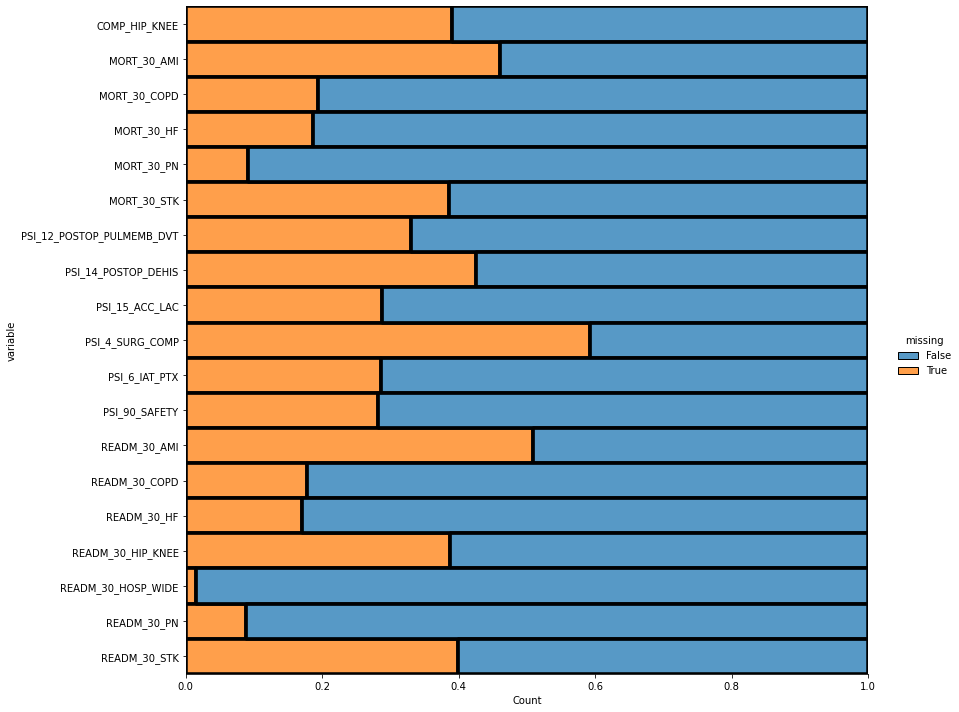

In [62]:
sns.displot(
    data=dataset.copy().drop(columns=['id','Closure']).isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=10,
    aspect=1.25
)
plt.show()

In [109]:
#save provider id data for future matching
match_id=np.array(dataset['id'])
dataset.drop(columns=['id'],inplace=True)
col_list=list(dataset)

# fill the variables with lower than 50% missing values by median value
list_fill_median=[]
for col in dataset:
    if dataset[col].isna().mean()<0.5:
        list_fill_median.append(col)
for col in list_fill_median:
    dataset[col].fillna(dataset[col].median(),inplace=True)

#multiple imputation
imputer=IterativeImputer()
dataset_=imputer.fit_transform(dataset)

In [114]:
#save quality of care data for future matching
dataset_to_match=pd.DataFrame(data=dataset_.copy(),columns=col_list)
dataset_to_match=dataset_to_match.assign(year=match_year,id=match_id)
dataset_to_match.to_csv('data/quality.csv')

# tuning and cross-validation

In [201]:
#Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(dataset_[:,:-1],
                                                    dataset_[:,-1],
                                                    test_size=0.3,
                                                    stratify=dataset_[:,-1]
                                                    )
#assign 10 stratified fold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10)

### Logistic Regression

In [209]:
classifier=LogisticRegression()
param_space={'classifier__C':(1e-5,1e+5,'log-uniform')}

oversampling=None
cv_score_LR,test_score_LR,list_best_cv_LR=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_LR_r,test_score_LR_r,list_best_cv_LR_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_LR_s,test_score_LR_s,list_best_cv_LR_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_LR_a,test_score_LR_a,list_best_cv_LR_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_LR_svm,test_score_LR_svm,list_best_cv_LR_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)


Classifier: LogisticRegression()
Over-sampling strategy: None
Cross-validation score: 0.0
Test score: 0.0
Best parameters: {'classifier__C': 13568.564552940306}

Classifier: LogisticRegression()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.024574808596957935
Test score: 0.02249718785151856
Best parameters: {'classifier__C': 0.0023264970501086593}

Classifier: LogisticRegression()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.023794755546332834
Test score: 0.021786492374727667
Best parameters: {'classifier__C': 0.003196389236626401}

Classifier: LogisticRegression()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.023852239511646223
Test score: 0.021762785636561484
Best parameters: {'classifier__C': 0.002142127930761389}

Classifier: LogisticRegression()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.0191180150119388
Test score: 0.0
Best parameters: {'classifier__C': 1.0027099227564134e-05}



### K Nearest Neighbors

In [210]:
classifier=KNeighborsClassifier()
param_space={'classifier__n_neighbors':Integer(1,10)}

oversampling=None
cv_score_knn,test_score_knn,list_best_cv_knn=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_knn_r,test_score_knn_r,list_best_cv_knn_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_knn_s,test_score_knn_s,list_best_cv_knn_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_knn_a,test_score_knn_a,list_best_cv_knn_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_knn_svm,test_score_knn_svm,list_best_cv_knn_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: KNeighborsClassifier()
Over-sampling strategy: None
Cross-validation score: 0.14337606837606837
Test score: 0.33333333333333337
Best parameters: {'classifier__n_neighbors': 1}

Classifier: KNeighborsClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.14988113335939424
Test score: 0.22535211267605634
Best parameters: {'classifier__n_neighbors': 6}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.1694700387331966
Test score: 0.1842105263157895
Best parameters: {'classifier__n_neighbors': 2}

Classifier: KNeighborsClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.16842175368491158
Test score: 0.18181818181818182
Best parameters: {'classifier__n_neighbors': 2}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.22896167557932262
Test score: 0.2222222222222222
Best parameters: {'classifier__n_neighbors': 2}



### Decision Tree

In [211]:
classifier=DecisionTreeClassifier()
param_space={'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__splitter':Categorical(['best','random']),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2',None])
            }

oversampling=None
cv_score_dt,test_score_dt,list_best_cv_dt=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_dt_r,test_score_dt_r,list_best_cv_dt_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_dt_s,test_score_dt_s,list_best_cv_dt_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_dt_a,test_score_dt_a,list_best_cv_dt_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_dt_svm,test_score_dt_svm,list_best_cv_dt_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: DecisionTreeClassifier()
Over-sampling strategy: None
Cross-validation score: 0.19492063492063494
Test score: 0.3636363636363637
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.22999999999999998
Test score: 0.2608695652173913
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 29, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.15341991341991343
Test score: 0.20512820512820515
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 114, 'classifier__max_features': None,

### Random Forest

In [212]:
classifier=RandomForestClassifier()
param_space={'classifier__n_estimators':Integer(10,500),
            'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2']),
            'classifier__max_leaf_nodes': Integer(2,50),
            'classifier__min_weight_fraction_leaf': Real(0,0.5)
            }

oversampling=None
cv_score_rf,test_score_rf,list_best_cv_rf=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
         
oversampling=RandomOverSampler()
cv_score_rf_r,test_score_rf_r,list_best_cv_rf_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_rf_s,test_score_rf_s,list_best_dt_rf_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_rf_a,test_score_rf_a,list_best_cv_rf_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_rf_svm,test_score_rf_svm,list_best_cv_rf_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: RandomForestClassifier()
Over-sampling strategy: None
Cross-validation score: 0.0
Test score: 0.0
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 340, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 38, 'classifier__min_samples_leaf': 16, 'classifier__min_samples_split': 7, 'classifier__min_weight_fraction_leaf': 0.08132062719718876, 'classifier__n_estimators': 442}

Classifier: RandomForestClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.2777056277056277
Test score: 0.4
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': 'auto', 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 50, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 500}

Classifier: RandomForestClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.3057142857142857
Test score

### XGBoost

In [215]:
classifier=XGBClassifier(booster='gbtree', tree_method='hist')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (1, 10),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 5),
             'classifier__n_estimators': (10, 500)   
        }

oversampling=None
cv_score_xg,test_score_xg,list_best_cv_xg=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_xg_r,test_score_xg_r,list_best_cv_xg_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_xg_s,test_score_xg_s,list_best_cv_xg_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_xg_a,test_score_xg_a,list_best_cv_xg_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_xg_svm,test_score_xg_svm,list_best_cv_xg_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='hist',
              validate_parameters=None, verbosity=None)
Over-sampling strategy: None
Cross-validation score: 0.22000000000000003
Test score: 0.2666666666666667
Best parameters: {'classifier__alpha': 0.00011522165978196937, 'classifier__learning_rate': 1.0, 'classifier__max_delta_step': 0, 'classifier__max_depth': 10, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 169, 'classifier__subsam

# Results' Plots

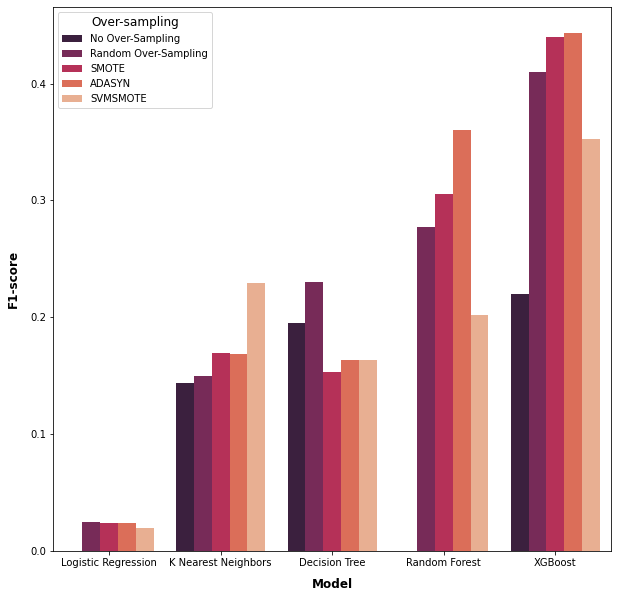

In [236]:
#Model comparison of cross-validation score
models_comparsion = pd.DataFrame({
    'Model': ['Logistic Regression','K Nearest Neighbors',
              'Decision Tree','Random Forest', 
              'XGBoost'],
    'No Over-Sampling':[cv_score_LR,cv_score_knn,cv_score_dt,cv_score_rf,cv_score_xg],
    'Random Over-Sampling':[cv_score_LR_r,cv_score_knn_r,cv_score_dt_r,cv_score_rf_r,cv_score_xg_r],
    'SMOTE': [cv_score_LR_s,cv_score_knn_s,cv_score_dt_s,cv_score_rf_s,cv_score_xg_s],
    'ADASYN': [cv_score_LR_a,cv_score_knn_a,cv_score_dt_a,cv_score_rf_a,cv_score_xg_a],
    'SVMSMOTE':[cv_score_LR_svm,cv_score_knn_svm,cv_score_dt_svm,cv_score_rf_svm,cv_score_xg_svm]
    })

plot_models_comp(models_comparsion)

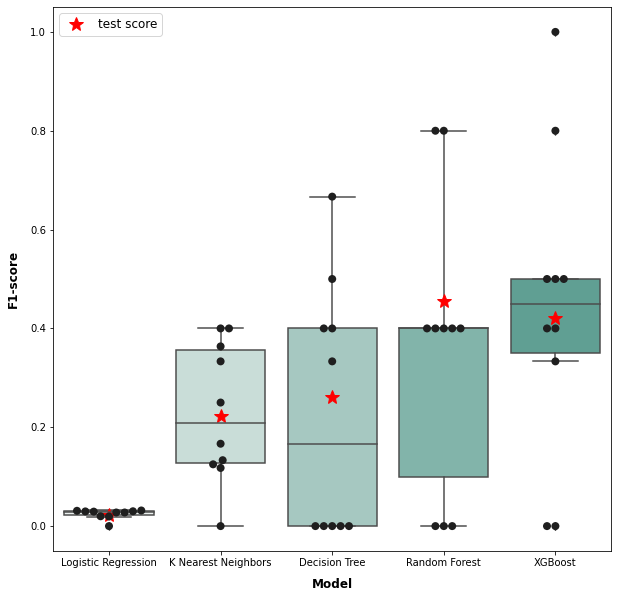

In [235]:
#Comparison of cross-validation score and test score of models with best over-sampling
cv_score=pd.DataFrame({
    'Logistic Regression':list_best_cv_LR_r,
    'K Nearest Neighbors':list_best_cv_knn_svm,
    'Decision Tree':list_best_cv_dt_r,
    'Random Forest':list_best_cv_rf_a, 
    'XGBoost':list_best_cv_xg_a
    })
test_score={
    'Logistic Regression':test_score_LR_r,
    'K Nearest Neighbors':test_score_knn_svm,
    'Decision Tree':test_score_dt_r,
    'Random Forest':test_score_rf_a, 
    'XGBoost':test_score_xg_a
    }

plot_cv_vs_test(cv_score,test_score)